In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import pickle
import datetime as date
import math
import seaborn as sns
sns.set()


from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score
%matplotlib inline

In [2]:
with open('final_data','rb') as read_file:
    df = pickle.load(read_file)

In [3]:
df.head(3)

,weight,camera,price,screen_size,length,width,thickness,battery,memory,RAM,log_price
0,169.0,13.0,250.0,5.5,153.8,75.6,8.5,4080.0,32000.0,3000.0,5.521461
1,166.0,13.0,230.0,5.5,153.3,78.8,8.5,4020.0,32000.0,3000.0,5.438079
2,125.0,8.0,110.0,5.0,145.7,71.2,8.4,2000.0,8000.0,1000.0,4.700480


In [26]:
df.describe()

,weight,camera,price,screen_size,length,width,thickness,battery,memory,RAM,log_price
count,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000
mean,160.547867,7.423635,199.496587,4.588712,137.335111,72.217449,10.585410,2223.553754,11904.408276,1194.003413,5.135868
std,81.846145,4.672745,123.055089,1.453705,28.332823,22.039365,3.024261,1132.758650,16184.379931,1068.846415,0.566413
min,47.000000,1.000000,10.000000,1.560000,44.000000,36.800000,4.700000,1.000000,8.000000,8.000000,2.302585
25%,124.675000,5.000000,120.000000,3.700000,118.500000,62.000000,8.500000,1500.000000,4000.000000,512.000000,4.787492
50%,142.000000,5.000000,170.000000,4.500000,133.300000,67.800000,9.900000,2000.000000,8000.000000,1000.000000,5.135798
75%,163.000000,8.000000,250.000000,5.200000,146.800000,73.900000,12.000000,2700.000000,16000.000000,2000.000000,5.521461
max,952.500000,41.000000,1400.000000,12.300000,300.300000,256.800000,28.200000,9600.000000,256000.000000,16000.000000,7.244228


In [37]:
df = df.drop('price', axis=1)

## Start Modeling w/StatsModel OLS

In [38]:
y_ols, X_ols = patsy.dmatrices('log_price ~ length + width + thickness + weight + memory + battery + screen_size + camera + RAM', 
                               data=df, return_type="dataframe")


model = sm.OLS(y_ols, X_ols)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     230.4
Date:                Sun, 21 Apr 2019   Prob (F-statistic):          1.91e-314
Time:                        18:02:43   Log-Likelihood:                -1247.9
No. Observations:                2344   AIC:                             2516.
Df Residuals:                    2334   BIC:                             2573.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       4.0173      0.138     29.176      0.000       3.747       4.287
length         -0.0015      0.001     -1.112      0.266      -0.004       0.001
width          -0.0061      0.002     -3.453      0.001      -0.010      -0.003
thickness       0.0435      0.006      7.812      0.000       0.033       0.054
weight          0.0023      0.000      5.522      0.000       0.001       0.003
memory       7.096e-06   8.72e-07      8.137      0.000    5.39e-06    8.81e-06
battery        2.5e-05    1.4e-05      1.786      0.074   -2.45e-06    5.25e-05
screen_size     0.0728      0.030      2.431      0.015       0.014       0.132
camera          0.0510      0.003     16.338      0.000       0.045       0.057
RAM          6.935e-05   1.69e-05      4.111      0.000    3.63e-05       0.000
==============================================================================
Omnibus:                       39.808   Durbin-Watson:                   1.199
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.993
Skew:                           0.015   Prob(JB):                     1.91e-17
Kurtosis:                       3.887   Cond. No.                     3.26e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.26e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

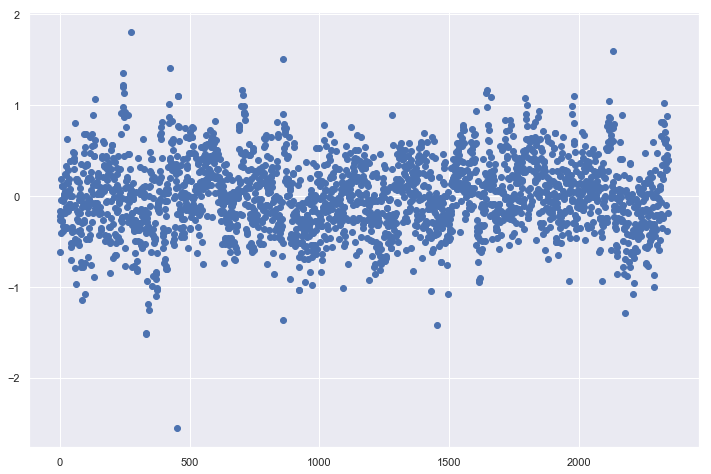

In [6]:
#checking residual plot again

fit.resid.plot(style='o', figsize=(12,8));

## Start Modeling w/ Different Regularization Techniques

In [39]:
X, y = df.drop('log_price',axis=1), df['log_price']

# hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=3)

In [40]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)

In [55]:
#instantiate models to test

lm = LinearRegression()
lm_regr = Ridge(alpha=175)
lm_regl = Lasso(alpha=0.006)
lm_poly = LinearRegression()


#feature scaling (needed for regularization)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

#transforms for polynomial model
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)



In [56]:
#validating all models above

lm.fit(X_train, y_train)
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')

lm_regr.fit(X_train_scaled, y_train)
print(f'Ridge Regression val R^2: {lm_regr.score(X_val_scaled, y_val):.3f}')

lm_regl.fit(X_train_scaled, y_train)
print(f'Lasso Regression val R^2: {lm_regl.score(X_val_scaled, y_val):.3f}')

lm_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')

Linear Regression val R^2: 0.446
Ridge Regression val R^2: 0.468
Lasso Regression val R^2: 0.457
Degree 2 polynomial regression val R^2: 0.494


In [61]:
list(zip(X.columns, lm_regr.coef_))

[('weight', 0.10422394358587457),
 ('camera', 0.21910101876178895),
 ('screen_size', 0.01608495866518642),
 ('length', 0.0016128098298043843),
 ('width', -0.02155527085035314),
 ('thickness', 0.11817166637096586),
 ('battery', 0.03553823583942963),
 ('memory', 0.11290543834636424),
 ('RAM', 0.06647304969753949)]

In [44]:
list(zip(X.columns, lm_regl.coef_))

[('weight', 0.12264440433603792),
 ('camera', 0.2882604653476811),
 ('screen_size', 0.0),
 ('length', -0.0),
 ('width', -0.0),
 ('thickness', 0.14490373872316853),
 ('battery', 0.015738224672854594),
 ('memory', 0.1201304695781126),
 ('RAM', 0.03586558795788493)]

In [45]:
list(zip(X.columns, lm.coef_))

[('weight', 0.0033514608475467564),
 ('camera', 0.06314421679185164),
 ('screen_size', 0.047998714053741044),
 ('length', -0.0023274870809571638),
 ('width', -0.007329431412313632),
 ('thickness', 0.042631396140424736),
 ('battery', 3.1065786844477664e-05),
 ('memory', 7.472719341945422e-06),
 ('RAM', 3.641850372113539e-05)]

## Modeling w/ Regularization and Cross-validation

In [57]:
kf = KFold(n_splits=5, shuffle=True, random_state = 30)
cross_val_score(lm, X, y, cv=kf, scoring='r2')

array([0.44405941, 0.48445379, 0.48532666, 0.44420497, 0.46483054])

In [58]:
cross_val_score(lm_regr, X, y, cv=kf, scoring='r2')

array([0.44551567, 0.48722919, 0.48318292, 0.44357012, 0.46331801])

In [59]:
cross_val_score(lm_regl, X, y, cv=kf, scoring='r2')

array([0.44646286, 0.48741447, 0.48192149, 0.44177966, 0.46162476])

In [60]:
print(np.mean(cross_val_score(lm_regr, X, y, cv=kf, scoring='r2')))
print(np.mean(cross_val_score(lm_regl, X, y, cv=kf, scoring='r2')))
print(np.mean(cross_val_score(lm, X, y, cv=kf, scoring='r2')))

0.46456317966606503
0.46384064670197295
0.46457507560541594


Ridge regression beats out non-regularized OLS by a tiny margin here, 

I was considering using Lasso as my champion model since it cut out the collinearly-related parameters such as length and width, but Ridge happened to give the higher score.

In [20]:
for feature, coef in zip(X.columns, lm_regr.coef_):
        print(feature, ':', f'{coef:.3f}')
        
print('\n')
lm_regr.intercept_

weight : 0.141
camera : 0.231
screen_size : 0.111
length : -0.010
width : -0.132
thickness : 0.159
battery : 0.043
memory : 0.127
RAM : 0.071




5.135279426210456

## Tuning Hyperparameters

In [50]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

In [51]:
alphalist = 10**(np.linspace(-3,3,300))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i,curr_alpha in enumerate(alphalist):

    
    steps = [('standardize', StandardScaler()), 
             ('lasso', Lasso(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train.loc[:,['weight', 'camera', 'screen_size', 
                            'length', 'width', 'thickness', 
                            'battery', 'memory', 'RAM']].values, y_train)
    
    val_set_pred = pipe.predict(X_val.loc[:,['weight', 'camera', 
                                             'screen_size', 'length', 
                                             'width', 'thickness', 
                                             'battery', 
                                             'memory', 'RAM']].values)
    err_vec_val[i] = mae(y_val, val_set_pred)

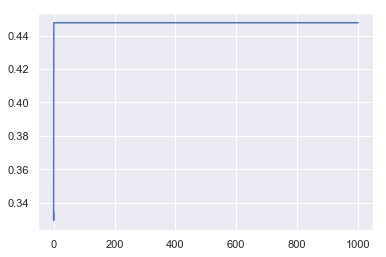

In [52]:
plt.plot(alphalist, err_vec_val)

It doesn't seem that regularization will really help the model much, but Lasso does help me select the important parameters

In [53]:
for i,curr_alpha in enumerate(alphalist):

    
    steps = [('standardize', StandardScaler()), 
             ('ridge', Ridge(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train.loc[:,['weight', 'camera', 'screen_size', 
                            'length', 'width', 'thickness', 
                            'battery', 'memory', 'RAM']].values, y_train)
    
    val_set_pred = pipe.predict(X_val.loc[:,['weight', 'camera', 
                                             'screen_size', 'length', 
                                             'width', 'thickness', 
                                             'battery', 
                                             'memory', 'RAM']].values)
    err_vec_val[i] = mae(y_val, val_set_pred)

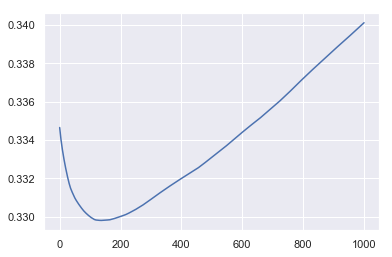

In [54]:
plt.plot(alphalist, err_vec_val)

## Model Prediction

In [62]:
selected_columns = ['weight', 'camera', 'screen_size', 
                            'length', 'width', 'thickness', 
                            'battery', 'memory', 'RAM']

In [63]:
test_set_pred = lm_regr.predict(X_test_scaled)

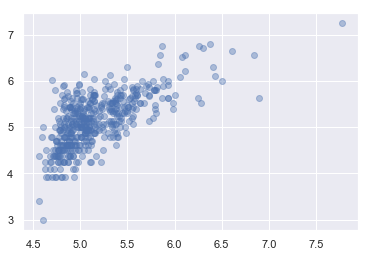

In [64]:
plt.scatter(test_set_pred, y_test, alpha=.4)

In [65]:
lm_regr.intercept_

5.130547367535022

In [66]:
r2_score(y_test, test_set_pred)

0.4612276326547089

In [67]:
mae(y_test, test_set_pred)

0.3316466744308365

In [68]:
list(zip(X_train.columns, lm_regr.coef_))

[('weight', 0.10422394358587457),
 ('camera', 0.21910101876178895),
 ('screen_size', 0.01608495866518642),
 ('length', 0.0016128098298043843),
 ('width', -0.02155527085035314),
 ('thickness', 0.11817166637096586),
 ('battery', 0.03553823583942963),
 ('memory', 0.11290543834636424),
 ('RAM', 0.06647304969753949)]